## Discovering Patterns in the Russian Housing Market for Analysis and Prediction
### 3804ICT Assignment Part I | Exponential Smoothing | Trimester 2, 2019

Joshua Russell (s5057545) | joshua.russell2@griffithuni.edu.au


Joshua Mitchell (s5055278) | joshua.mitchell4@griffithuni.edu.au


Hayden Flatley (s5088623) | hayden.flatley@griffithuni.edu.au

#### Note

This notebook only contains the R (HoltWinters) implementation for the Exponential Smoothing study. Please refer to the notebook entitled *"Exponential Smoothing"* for the other sections of the study.

### R (Holt Winters) Library Solution, Results and Metrics

In [1]:
# Imports
require(ggplot2)
require(forecast)
library(repr)
library(plyr) 

# Load dataset from csv file
data <- read.csv("file=../../train_df_monthly_average.csv", sep=",")
data <- data[, c("yearMonth", "price_doc")]

# Split dataset into training and test sets
df_train = data[0:floor(0.8 * nrow(data)), ]
df_test = data[floor(0.8 * nrow(data) + 1: nrow(data)),]

# Extract the `price_doc` attribute values and convert to time series object
dfts_train <- ts(df_train$price_doc, frequency=12)
dfts_test <- ts(df_test$price_doc, frequency=12)

Loading required package: ggplot2
Loading required package: forecast
Registered S3 method overwritten by 'xts':
  method     from
  as.zoo.xts zoo 
Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 
Registered S3 methods overwritten by 'forecast':
  method             from    
  fitted.fracdiff    fracdiff
  residuals.fracdiff fracdiff


In [2]:
# Train and test (i.e. forecast sale price) using the HoltWinters exponential smoothing model and record runtime
options(repr.plot.width=12, repr.plot.height=8)
runtime <- function() {
    ts <- ts(dfts_train, frequency=6)
    (m <- HoltWinters(ts, seasonal = "additive", start.periods=2))
    predictions <- predict(m, n = 12)
}

# Display the run time for training and testing the model, plot graphs of the time series components, and plot a
# graph showing the forecasts of the model in comparison to the test set time series.
system.time(r_time <- runtime())

   user  system elapsed 
   0.03    0.00    0.03 

Holt-Winters exponential smoothing with trend and additive seasonal component.

Call:
HoltWinters(x = ts, seasonal = "additive", start.periods = 2)

Smoothing parameters:
 alpha: 0.6688468
 beta : 0.03471471
 gamma: 0.7402606

Coefficients:
          [,1]
a  7704304.072
b    89573.230
s1   94440.000
s2  -59754.227
s3 -215107.250
s4 -351322.116
s5 -147285.825
s6    1937.337

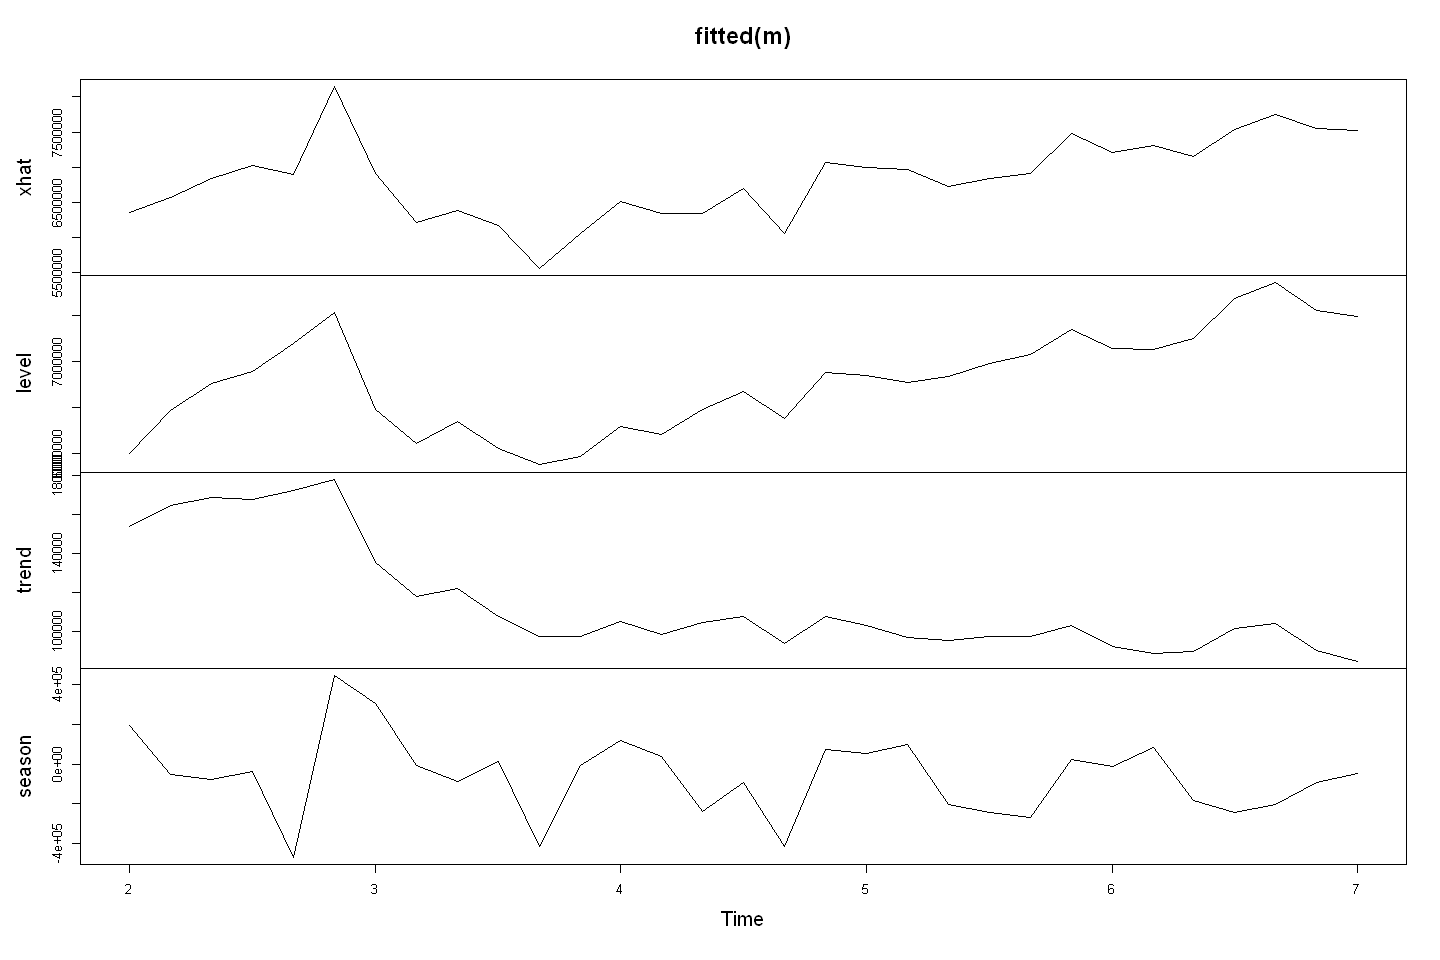

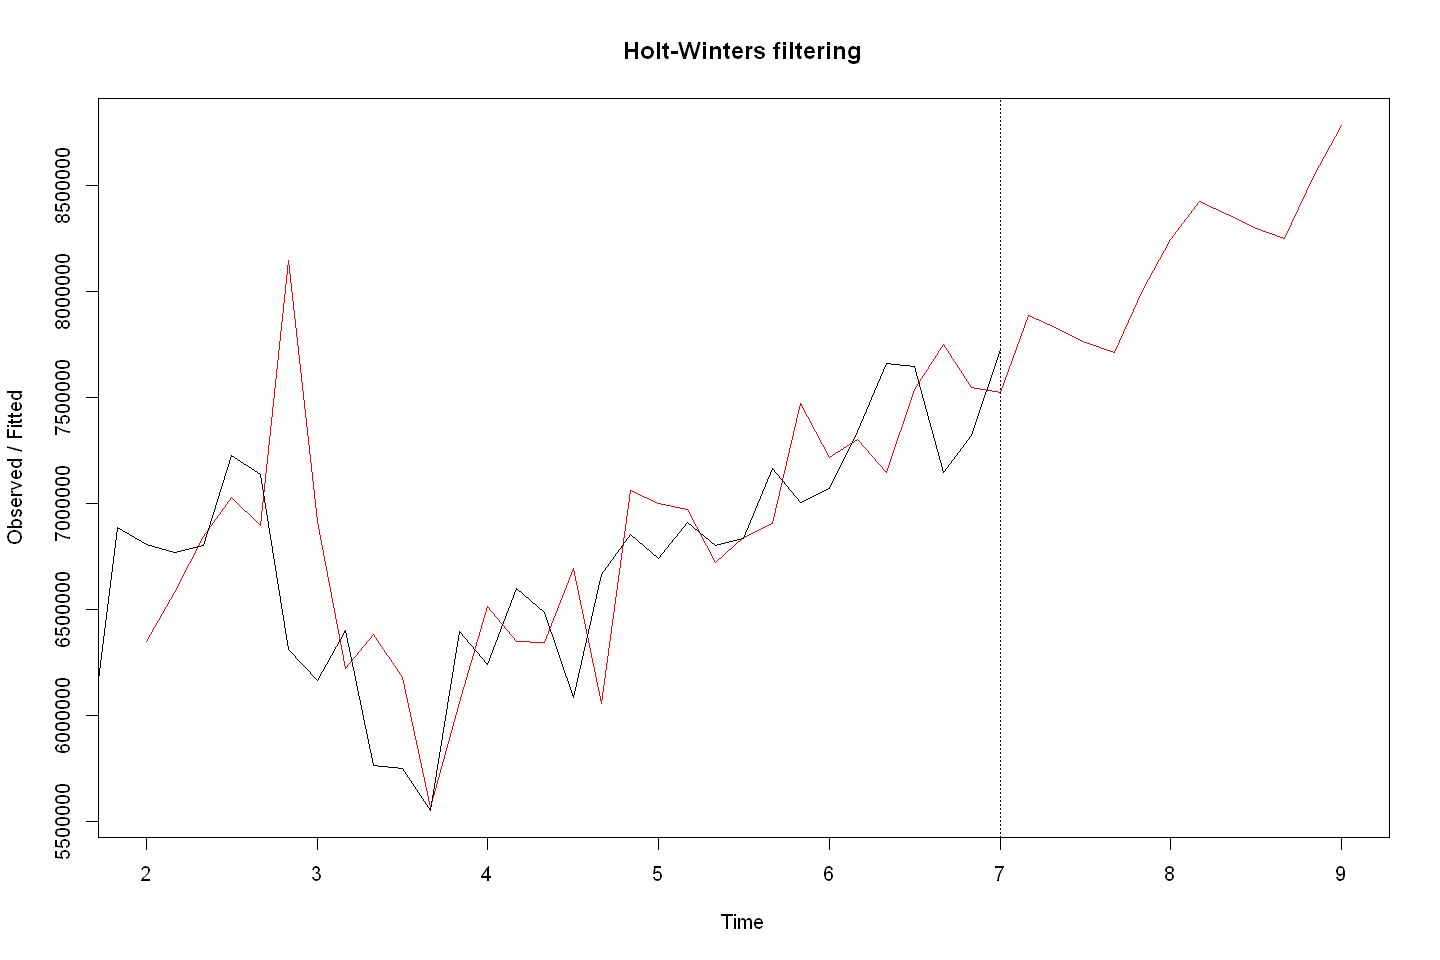

In [3]:
ts <- ts(dfts_train, frequency=6)
(m <- HoltWinters(ts, seasonal = "additive", start.periods=2))
predictions <- predict(m, n = 12)
plot(fitted(m))
plot(m, predictions)

In [4]:
# Fitted holt winters doesn't keep the first seasonal period with the 12 initial values, so our final length is 36
final <- append(fitted(m)[, 'xhat'], predictions, after = length(m))

# Calculate the mean squared error (MSE) and mean absolute error (MAE) of the HoltWinters final forecast predictions
mse_results = data.frame(mean((data[, "price_doc"] - final)^2))
mae_results = data.frame(mean((data[, "price_doc"] - final)^2))

# Perform rolling forecasting origin cross validation
for (i in 2:17){
    ts <- ts(dfts_train, frequency=i)
    (m <- HoltWinters(ts, seasonal="additive", alpha=0.334, beta=0.0137, gamma=0.635))
    predictions <- predict(m, n=12)
    final <- append(fitted(m)[, 'xhat'], predictions, after = length(m))
    mse_results[i, ] = mean((data[, "price_doc"] - final)^2)
    mae_results[i, ] = mean(abs(data[, "price_doc"] - final))  
}

# 
ts <- ts(dfts_train, frequency=i)
(m <- HoltWinters(ts, seasonal="additive"))
predictions <- predict(m, n=24)
final <- append(fitted(m)[, 'xhat'], predictions, after = length(m))

# Write results to file
# write.csv(mse_results, "R_Forecasting_MSE.csv")
# write.csv(mae_results, "R_Forecasting_MAE.csv")
# write.csv(final, "R_Forecasting_Results.csv")

Warning message in data[, "price_doc"] - final:
"longer object length is not a multiple of shorter object length"Warning message in data[, "price_doc"] - final:
"longer object length is not a multiple of shorter object length"Warning message in data[, "price_doc"] - final:
"longer object length is not a multiple of shorter object length"Warning message in data[, "price_doc"] - final:
"longer object length is not a multiple of shorter object length"Warning message in data[, "price_doc"] - final:
"longer object length is not a multiple of shorter object length"Warning message in data[, "price_doc"] - final:
"longer object length is not a multiple of shorter object length"Warning message in data[, "price_doc"] - final:
"longer object length is not a multiple of shorter object length"Warning message in data[, "price_doc"] - final:
"longer object length is not a multiple of shorter object length"Warning message in data[, "price_doc"] - final:
"longer object length is not a multiple of short

Holt-Winters exponential smoothing with trend and additive seasonal component.

Call:
HoltWinters(x = ts, seasonal = "additive")

Smoothing parameters:
 alpha: 0.8248785
 beta : 0
 gamma: 0

Coefficients:
            [,1]
a   7474252.7803
b     21130.6685
s1    81049.1874
s2  -367238.2247
s3   173743.1053
s4   268396.7857
s5    45805.2040
s6   310809.8470
s7   923271.9343
s8   817541.4087
s9   -51839.1976
s10 -221029.6494
s11    1694.2698
s12 -621488.2601
s13 -640403.3469
s14 -835869.9455
s15     136.8328
s16 -131015.6078
s17  246435.6570

In [5]:
# Defining time series variables for cross validation
seasonal_period = 6
forecast_step_size = 3
split_point = seasonal_period * 2 + 1

# Split dataset into training and test sets
df_train = data[0:(split_point), ]
df_test = data[(split_point + 1): (split_point + forecast_step_size), ]

# Extract the `price_doc` attribute values and convert to time series object
dfts_train <- ts(df_train$price_doc, frequency=seasonal_period)
dfts_test <- ts(df_test$price_doc, frequency=seasonal_period)

# Calculate the mean absolute error (MAE) for the rolling forecasting origin cross validation time series predictions
mae_rolling_results = list()
for (i in split_point:(nrow(data) - forecast_step_size  - 1 )) {
    ts <- ts(dfts_train, frequency=seasonal_period)
    (m <- HoltWinters(ts, seasonal="additive", alpha=0.334, beta=0.0137, gamma=0.635))
    predictions <- predict(m, n=forecast_step_size)
    mae_rolling_results <- append(mae_rolling_results, mean(abs(predictions - dfts_test)))

    df_train <- data[0:(i), ]
    df_test <- data[(i + 1): (i + forecast_step_size), ]
    
    dfts_train <- ts(df_train$price_doc, frequency=seasonal_period)
    dfts_test <- ts(df_test$price_doc, frequency=seasonal_period)
}
mae_rolling_results.df <- do.call("rbind", lapply(mae_rolling_results, as.data.frame)) 
mae_rolling_results

# Write results to file
# write.csv(mae_rolling_results.df, "Rolling_MAE.csv")

Warning message in .cbind.ts(list(e1, e2), c(deparse(substitute(e1))[1L], deparse(substitute(e2))[1L]), :
"non-intersecting series"Warning message in .cbind.ts(list(e1, e2), c(deparse(substitute(e1))[1L], deparse(substitute(e2))[1L]), :
"non-intersecting series"Warning message in .cbind.ts(list(e1, e2), c(deparse(substitute(e1))[1L], deparse(substitute(e2))[1L]), :
"non-intersecting series"Warning message in .cbind.ts(list(e1, e2), c(deparse(substitute(e1))[1L], deparse(substitute(e2))[1L]), :
"non-intersecting series"Warning message in .cbind.ts(list(e1, e2), c(deparse(substitute(e1))[1L], deparse(substitute(e2))[1L]), :
"non-intersecting series"Warning message in .cbind.ts(list(e1, e2), c(deparse(substitute(e1))[1L], deparse(substitute(e2))[1L]), :
"non-intersecting series"Warning message in .cbind.ts(list(e1, e2), c(deparse(substitute(e1))[1L], deparse(substitute(e2))[1L]), :
"non-intersecting series"Warning message in .cbind.ts(list(e1, e2), c(deparse(substitute(e1))[1L], deparse(s

[[1]]
[1] NaN

[[2]]
[1] NaN

[[3]]
[1] NaN

[[4]]
[1] NaN

[[5]]
[1] NaN

[[6]]
[1] NaN

[[7]]
[1] NaN

[[8]]
[1] NaN

[[9]]
[1] NaN

[[10]]
[1] NaN

[[11]]
[1] NaN

[[12]]
[1] NaN

[[13]]
[1] NaN

[[14]]
[1] NaN

[[15]]
[1] NaN

[[16]]
[1] NaN

[[17]]
[1] NaN

[[18]]
[1] NaN

[[19]]
[1] NaN

[[20]]
[1] NaN

[[21]]
[1] NaN

[[22]]
[1] NaN

[[23]]
[1] NaN

[[24]]
[1] NaN

[[25]]
[1] NaN

[[26]]
[1] NaN

[[27]]
[1] NaN

[[28]]
[1] NaN

[[29]]
[1] NaN

[[30]]
[1] NaN

[[31]]
[1] NaN